# Stock Prediction - For dummmies in Python

First we import the dependencies needed for this project.
The pandas_datareader.data allows us to get the most recent financial data.

In [7]:
import matplotlib as mpl
import os
import numpy as np
import pandas as pd
import datetime
import pandas_datareader.data as web
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')
%matplotlib inline 
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso

Here we define a start and end date for how the periode of time that we want to grab the stocks ( year, month, day) and we define the stock(s) that we are interested in.

In [4]:
start = datetime.datetime(2010, 1, 1)
end = datetime.datetime(2020, 1, 11)
stock = "AAPL"

df = web.DataReader(stock, 'yahoo', start, end)
df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2010-01-04,30.642857,30.340000,30.490000,30.572857,123432400.0,26.681330
2010-01-05,30.798571,30.464285,30.657143,30.625713,150476200.0,26.727465
2010-01-06,30.747143,30.107143,30.625713,30.138571,138040000.0,26.302330
2010-01-07,30.285715,29.864286,30.250000,30.082857,119282800.0,26.253704
2010-01-08,30.285715,29.865715,30.042856,30.282858,111902700.0,26.428249


# Adjusted closing price
Adjusted closing price amends a stock's closing price to accurately reflect that stock's value after accounting for any corporate actions. The closing price is the 'raw' price which is just the cash value of the last transacted price before the market closes.

## Rolling average
Stocks might be very volatile, so in order to handle this, we create a rolling average, that takes for a given day the average of the adjusted closing price for the last 10 days average.


In [5]:
close_px = df['Adj Close']
mavg = close_px.rolling(window=10).mean()

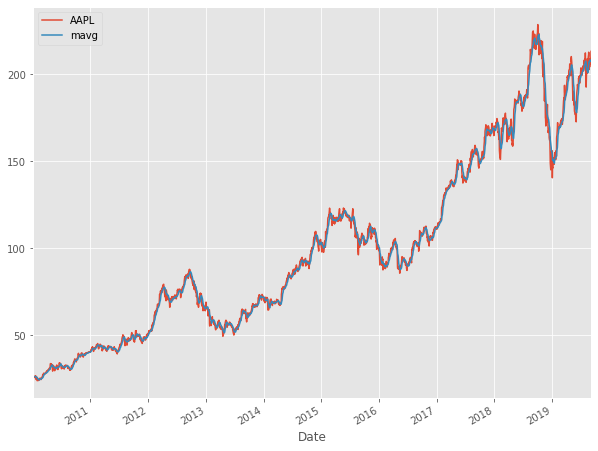

In [14]:
style.use('ggplot')
mpl.rc('figure', figsize=(10, 8))
close_px.plot(label='AAPL')
mavg.plot(label='mavg')
plt.legend();

The red curve is the actual stock while the blue curve displays the rolling average. As one can see the rolling average is good at detecting the trend of the stock, but it happens a little while after the stock has actually done its thing.

# Stockreturn - is it good or bad?

One way to see if a stock is good or bad is to look at the return of the stock - in other words: How much the stock has changed during the day compared to how it was when it started the day. The bigger the spikes, the more the stock changes.

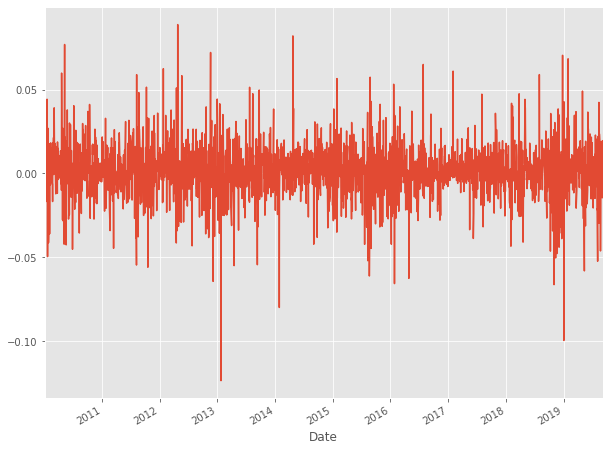

In [15]:
rets = close_px / close_px.shift(1) - 1
rets.plot(label='return');

Here the stock's return seems to be between -10% and +7.5% . Different stocks have different returns, so to get an idea of this we use a boxplot. We also load in the data for the Facebook stock to have something to compare our Apple prediction to.

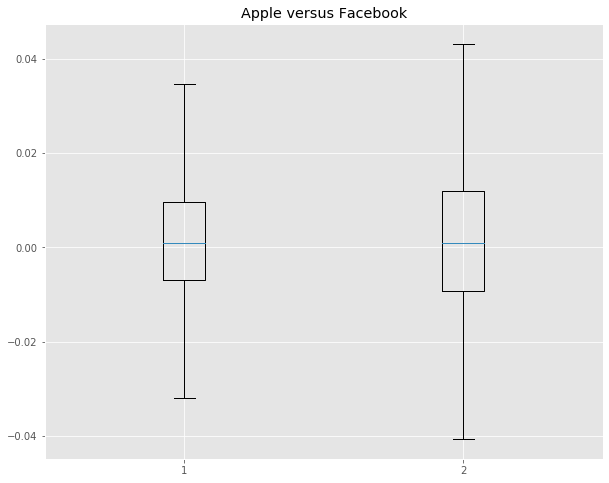

In [16]:
df1 = web.DataReader("FB", 'yahoo', start, end)
close_px1 = df1['Adj Close']
rets1 = close_px1 / close_px1.shift(1) - 1
data=[rets[1:], rets1[1:]] # we create a data variable, where the first part is Apple, and the second part is Facebook

fig1, ax1 = plt.subplots()
ax1.set_title('Apple versus Facebook')
ax1.boxplot(data, showfliers=False);

As one can see the Apple stock is more stable than the Facebook stock, since the variation is smaller. 

We now add two new colums to our dataset:
    
hl_change: Percentage change of the High and Low columns. <br>
pct_change:Percentage change of the closing and opening price.

In [17]:
df['hl_change'] = ((df['High']-df['Low'])/df['Close'])*100
df['pct_change'] = ((df['Close']-df['Open'])/df['Open'])*100
df.tail()

,High,Low,Open,Close,Volume,Adj Close,hl_change,pct_change
Date,,,,,,,,
2019-08-30,210.449997,207.199997,210.160004,208.740005,21143400.0,208.740005,1.556961,-0.675675
2019-09-03,206.979996,204.220001,206.429993,205.699997,20023000.0,205.699997,1.341757,-0.353629
2019-09-04,209.479996,207.320007,208.389999,209.190002,19188100.0,209.190002,1.032549,0.383897
2019-09-05,213.970001,211.509995,212.000000,213.279999,23913700.0,213.279999,1.153417,0.603773
2019-09-06,214.419998,212.509995,214.050003,213.259995,19350800.0,213.259995,0.895622,-0.369077


# Prediction time

First we do a 80/20 split of our data using the sklearn function

In [18]:
df_work = df
df_train,df_test = train_test_split(df_work,train_size=0.8,random_state=42,shuffle=False)
df_train.head()

,High,Low,Open,Close,Volume,Adj Close,hl_change,pct_change
Date,,,,,,,,
2010-01-04,30.642857,30.340000,30.490000,30.572857,123432400.0,26.681330,0.990606,0.271752
2010-01-05,30.798571,30.464285,30.657143,30.625713,150476200.0,26.727465,1.091520,-0.102519
2010-01-06,30.747143,30.107143,30.625713,30.138571,138040000.0,26.302330,2.123523,-1.590633
2010-01-07,30.285715,29.864286,30.250000,30.082857,119282800.0,26.253704,1.400893,-0.552538
2010-01-08,30.285715,29.865715,30.042856,30.282858,111902700.0,26.428249,1.386924,0.798864


We now want our model to predict the Adjusted close column, so we set that as our y and our X as the rest. 

In [19]:
y = df_train['Adj Close']
X = df_train.drop(columns=['Adj Close'])

# Model testing - Linear regression

In [20]:
lin_reg = LinearRegression()
lin_reg.fit(X,y);

With our data now fitted to the model, we have to figure out how well the model predicts the data.

In [21]:
y_pred = lin_reg.predict(X) 
score = mean_squared_error(y,y_pred)
np.sqrt(score)

1.7631534822328288

In [22]:
df_train['forecast'] = y_pred # Creates a new column in the dataframe named forecast

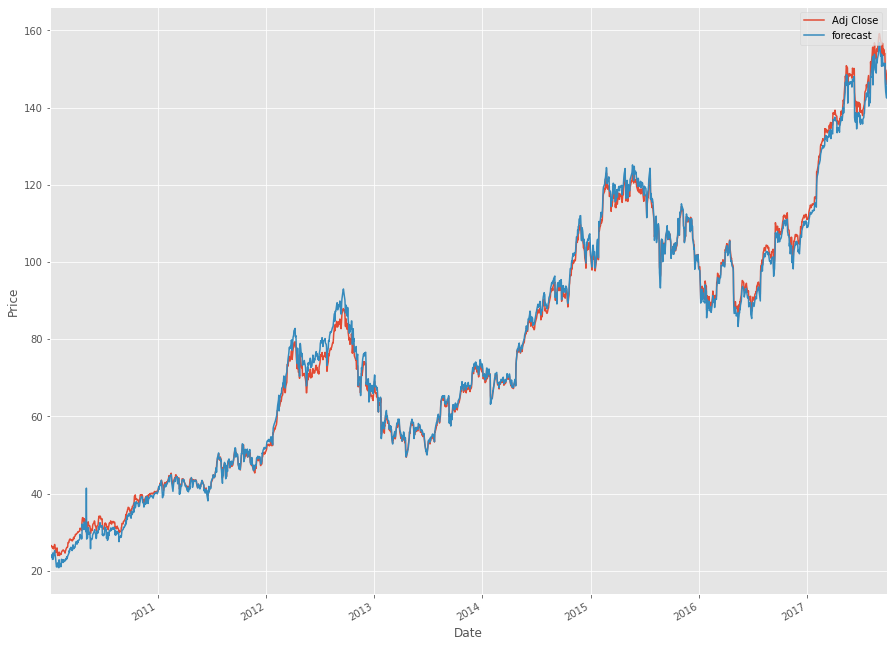

In [23]:
df_train['Adj Close'].plot(figsize=(15,12))
df_train['forecast'].plot(figsize=(15,12))
plt.legend(loc=1)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

This model seems to be working well, but we want to explore other models as well. Since we will be plotting graphs for all the predictions, we define a plot_graph function. Since we will be doing K-Fold Cross Validation to determine which model is the best, we also define a function for that. 

In [24]:
def plot_graph(self):
    df_train['forecast'] = self
    df_train['Adj Close'].plot(figsize=(14,8),)
    df_train['forecast'].plot(figsize=(14,8),)
    plt.legend(loc=4)
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.show()   
  
def cross_val(self):
    scores = cross_val_score(self, X,y,scoring='neg_mean_squared_error',cv=10)
    rmse_cross_val = np.sqrt(-scores)
    
    
    print('Scores: ',-scores)
    print("Mean: ", -scores.mean())
    print("Standard Deviation: ", scores.std())

In [25]:
cross_val(lin_reg)

Scores:  [13.10569276  0.85350653  2.28375932 12.35959175  0.46568774  1.17546175
  3.96365346  1.56787077  4.05783348 19.23562024]
Mean:  5.906867779606332
Standard Deviation:  6.22731316744702


Here we see, that the mean error is around 5.9 and the standard deviation from the mean around 6.2.

# Ridge Regression

Ridge Regression is a neat little way to ensure you don't overfit your training data - essentially, you are desensitizing your model to the training data.

In [26]:
ridge = Ridge(random_state=42)
ridge.fit(X,y)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=42, solver='auto', tol=0.001)

In [27]:
y_pred_ridge = ridge.predict(X)

In [28]:
mse_ridge = mean_squared_error(y,y_pred_ridge)
rmse_ridge = np.sqrt(mse_ridge)
rmse_ridge

1.7631593333340687

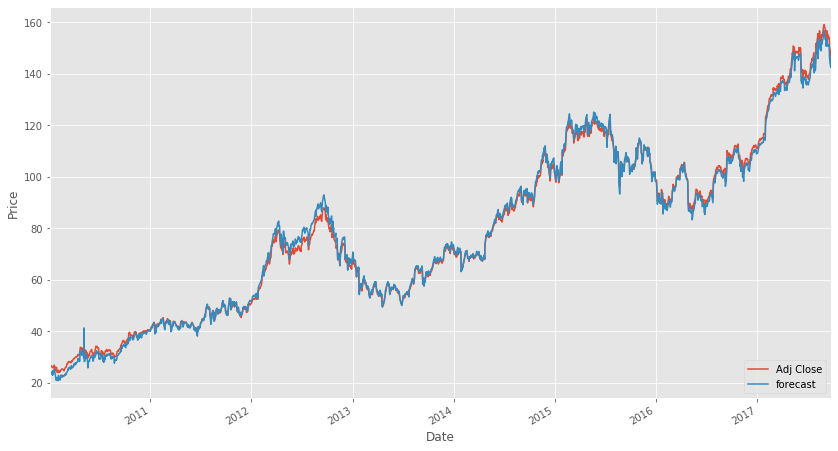

In [29]:
plot_graph(y_pred_ridge)

In [30]:
cross_val(ridge)

Scores:  [12.98248405  0.85104126  2.28877692 12.36900917  0.46501248  1.17456817
  3.96523309  1.55221704  4.06056142 19.26128637]
Mean:  5.897018997689505
Standard Deviation:  6.220653746956007


# Lasso regression

In [31]:
lass_reg = Lasso(alpha=0.55,random_state=42)
lass_reg.fit(X,y)

Lasso(alpha=0.55, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=42,
      selection='cyclic', tol=0.0001, warm_start=False)

In [32]:
y_pred_lass = lass_reg.predict(X)

In [33]:
mse_lass = mean_squared_error(y,y_pred_lass)
rmse_lass = np.sqrt(mse_lass)
rmse_lass

1.9132247198581787

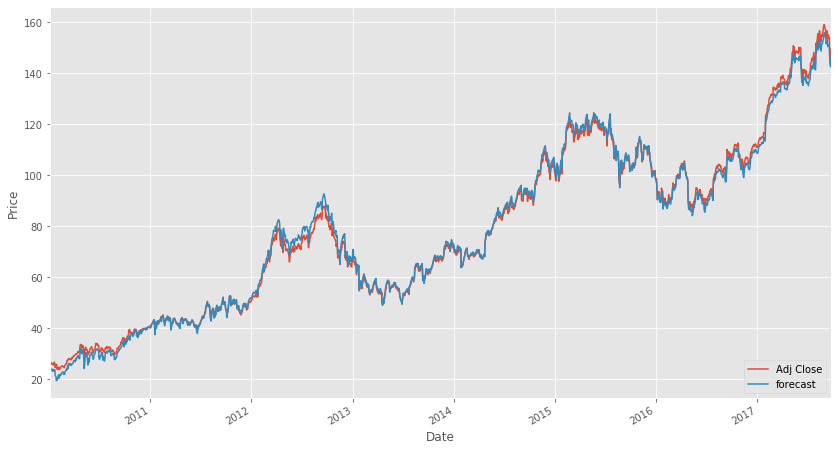

In [34]:
plot_graph(y_pred_lass)

In [35]:
cross_val(lass_reg)

Scores:  [14.28995447  0.75337091  2.85978829 13.69195442  0.60796779  1.22377964
  4.91561756  1.40760545  4.66924996 22.45980899]
Mean:  6.687909747894477
Standard Deviation:  7.123158211279867


# Time to test

After running the 3 tests above we can see that Ridge Regression is a slightly the better one. Please note, that there are alot of data going into each model, so this might also be a factor. 

First we split the data

In [36]:
y_test = df_test['Adj Close']
X_test = df_test.drop(columns=['Adj Close'])

Then we make the prediction

In [37]:
y_test_pred = ridge.predict(X_test)

And we calculate the error

In [38]:
final_mse=mean_squared_error(y_test,y_test_pred)
final_rmse=np.sqrt(final_mse)

final_rmse

6.546091367307634

In [40]:
def plot_graph_test(self):
    df_test['forecast'] = self
    df_test['Adj Close'].plot(figsize=(14,8),)
    df_test['forecast'].plot(figsize=(14,8),)
    plt.legend(loc=4)
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.show()

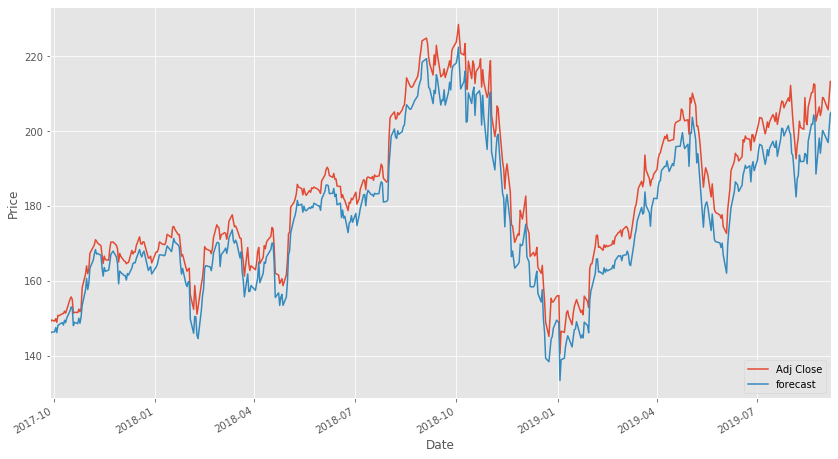

In [41]:
plot_graph_test(y_test_pred)

Not so good, but better than no prediction at all :) 